## Trabajo Semanal 6 - BETTIG
### Estimación espectral a prueba: Ancho de banda del Electrocardiograma.

<br> En el archivo <b>ECG_TP4.mat</b> encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:
 - Ruido causado por el movimiento de los electrodos (Alta frecuencia)
 - Ruido muscular (Alta frecuencia)
 - Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia)

Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a suavidad de los trazos y nivel isoeléctrico nulo.


### Desarrollo del Trabajo

#### Tipos de Pulsos y PSD

Primero que nada, voy a incluir las bibliotecas necesarias para el desarrollo de la tarea

In [14]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig

def vertical_flaten(a):
  return a.reshape(a.shape[0],1)

def filter_design(ripple = 0, att = 40, ws1 = 0.1, wp1 = 1.0, wp2 = 40.0, ws2 = 50.0, fs = 1000):
    return sig.iirdesign(wp=np.array([wp1, wp2]) / (fs/2), ws=np.array([ws1, ws2]) / (fs/2), gpass=ripple, gstop=att, analog=False, ftype='butter', output='sos')


Luego, voy a sacar todo lo necesario del archivo <b>ECG_TP4.mat</b>. Del mismo obtendré la señal de ECG ("ecg_lead") y la posición temporal en donde se produjo la onda R ("qrs_detections") para luego poder separar cada uno de los pulsos y poder operar con ellos.

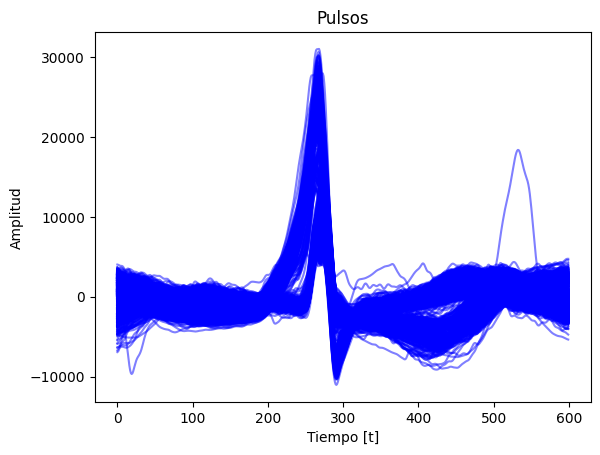

In [2]:
# Para listar las variables que hay en el archivo
mat_struct = sio.loadmat('./ECG_TP4.mat')
fs = 1000

# Me quedo con todas las muestras de ECG
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])

# Profundidad que tendrá cada una de las muestras por separado. Desde el punto
# máximo me moveré N1 muestras para atrás y N2 muestras hacia adelante
N = 600;
N1 = 270;
N2 = N - N1

# Obtengo todos los puntos donde tengo los máximos relativos y la longitud
# de dicho vector (Cantidad de picos)
qrs_peak = vertical_flaten(mat_struct['qrs_detections'])
n_run = len(qrs_peak)

# Creo unos arrays vacios donde voy a guardar todas las muestras
ecg_samples         = np.empty((n_run, N), float);
ecg_samples_detrend = np.empty((n_run, N), float);
ecg_norm            = np.empty((n_run, N), float);

# Empiezo a recorrer el vector hasta encontrar uno de estos picos, luego
# guardo N1 muestras hacia atras y N2 muestras hacia adelante
# Con detrend elimino la tendencia que tenga mi señal
for i in range(n_run):
    index = qrs_peak[i][0];
    ecg_samples[i] = np.reshape(ecg_one_lead[index-N1:index+N2], [N,])
    ecg_samples_detrend[i] = sig.detrend(ecg_samples[i])

# Ploteo los resultados obtenidos
plt.figure(2)
plt.plot(np.transpose(ecg_samples_detrend[0]), 'b', alpha=0.5)
plt.plot(np.transpose(ecg_samples_detrend), 'b', alpha=0.5)
plt.title('Pulsos');
plt.xlabel('Tiempo [t]');  
plt.ylabel('Amplitud');

Luego, me ecargaré de separar entre pulsos normales y ventriculares. Para ello, lo primero que haré será normalizar todos los pulsos en amplitud, es decir, obtendré el valor máximo y lo usaré de patrón. Luego, voy a fijar un umbral con el cual determinaré que todas las señales que estén por encima del mismo serán ventricualares, y normales aquellos que no. 

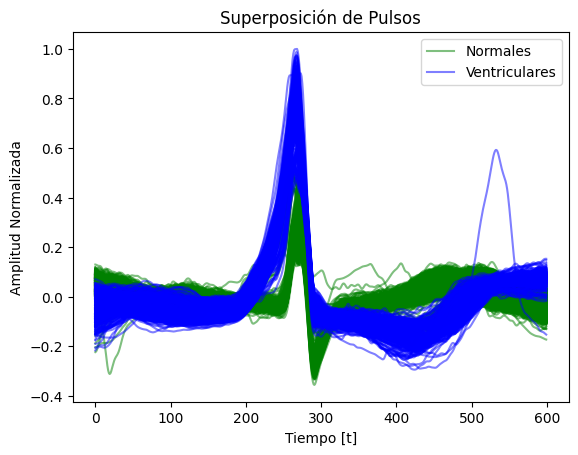

In [3]:
# Voy a separar entre latidos normales y ventriculares. Para ello, primero
# voy a buscar el valor máximo para normalizar las señales:
max_value = 0.0;
max_aux = 0.0;
for i in range(n_run):
    max_aux = np.max(ecg_samples_detrend[i])
    if(max_value < max_aux):
        max_value = max_aux;
for i in range(n_run):
    ecg_norm[i] = ecg_samples_detrend[i]/max_value;

# Para separar entre normales y ventriculares lo que voy a hacer es 
# determinar cuales de los pulsos superan cierto umbral(ventriculares).
# Los que no lo superan, seran normales
peak_threshold = 0.5;
pulse_norm = np.array([]);
pulse_vent = np.array([]);
for i in range(n_run):
    if (np.max(ecg_norm[i]) < peak_threshold):
        pulse_norm = np.append(pulse_norm, ecg_norm[i], axis = 0);
    else:
        pulse_vent = np.append(pulse_vent, ecg_norm[i], axis = 0);
pulse_norm = np.reshape(pulse_norm, ((len(pulse_norm)//N), N));
pulse_vent = np.reshape(pulse_vent, ((len(pulse_vent)//N), N));
# Ploteo los resultados obtenidos
plt.figure(3)
plt.plot(np.transpose(pulse_norm[0]), 'g', alpha=0.5, label = 'Normales')
plt.plot(np.transpose(pulse_vent[0]), 'b', alpha=0.5, label = 'Ventriculares')
plt.plot(np.transpose(pulse_norm), 'g', alpha=0.5)
plt.plot(np.transpose(pulse_vent), 'b', alpha=0.5)
plt.title('Superposición de Pulsos');
plt.xlabel('Tiempo [t]');
plt.ylabel('Amplitud Normalizada');  
plt.legend();

Ahora, voy a promediar todos los pulsos normales y todos los pulsos ventriculares para obtener un pulso promedio (Uno normal y uno ventricular), con el que calcularé la PSD y luego los límites superiores e inferiores del filtro

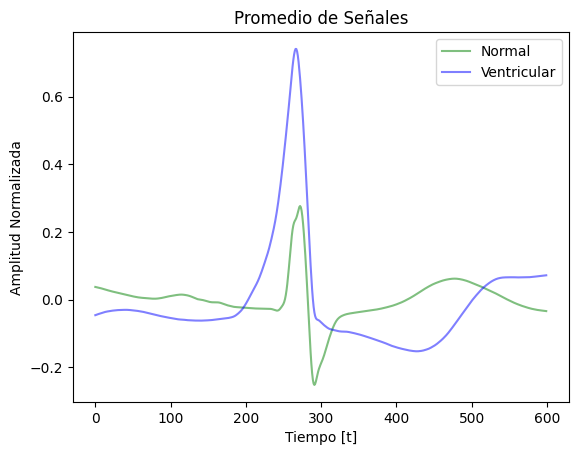

In [4]:
# Luego, voy a promediar todos los pulsos normales y los ventriculares entre
# si para obtener un pulso promedio, con el que trabajaré a partir de este 
# momento. El mismo me servirá para poder conocer el contenido espectral de
# la señal
pulse_norm_avg = np.average(np.transpose(pulse_norm), axis = 1)
pulse_vent_avg = np.average(np.transpose(pulse_vent), axis = 1)
plt.figure(4)
plt.plot(np.transpose(pulse_norm_avg), 'g', alpha=0.5, label = 'Normal')
plt.plot(np.transpose(pulse_vent_avg), 'b', alpha=0.5, label = 'Ventricular')
plt.title('Promedio de Señales');
plt.xlabel('Tiempo [t]');
plt.ylabel('Amplitud Normalizada');  
plt.legend();

Para obtener la PSD de las señales voy a utilizar el método de Welch. A partir de ella, podré conocer el límite superior e inferior del filtro

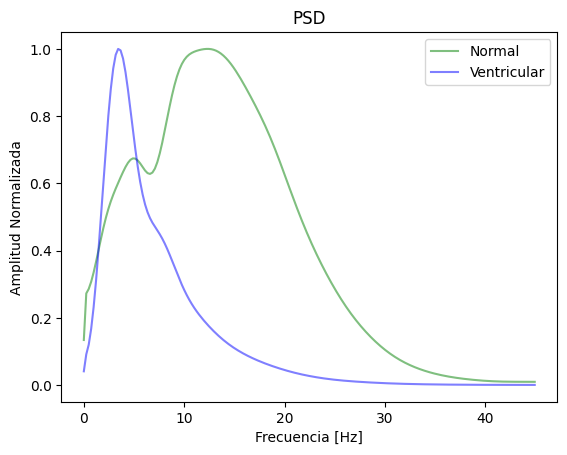

In [5]:
# Obtengo la PSD de ambos vectores a través de Welch
len_norm    = len(pulse_norm);
len_vent    = len(pulse_vent);
welch_norm  = np.empty((len_norm, 2049), float);
welch_vent  = np.empty((len_vent, 2049), float);
for i in range(len_norm):
    f_norm, welch_norm[i] = sig.welch(pulse_norm[i], fs, 'blackman', N, nfft = 4096, return_onesided=True)
for i in range(len_vent):
    f_vent, welch_vent[i] = sig.welch(pulse_vent[i], fs, 'blackman', N, nfft = 4096, return_onesided=True)
welch_norm_avg = np.average(np.transpose(welch_norm), axis = 1)
welch_vent_avg = np.average(np.transpose(welch_vent), axis = 1)
frec_filter = f_norm < 45
plt.figure(5)
plt.plot(f_norm[frec_filter], welch_norm_avg[frec_filter]/np.max(welch_norm_avg[frec_filter]), '-g', alpha=0.5, label = 'Normal')
plt.plot(f_vent[frec_filter], welch_vent_avg[frec_filter]/np.max(welch_vent_avg[frec_filter]), '-b', alpha=0.5, label = 'Ventricular')
plt.title('PSD');
plt.xlabel('Frecuencia [Hz]');  
plt.ylabel('Amplitud Normalizada');  
plt.legend();

Ahora tengo que obtener el límite inferior y el superior de cada una de las señales. El inferior lo obtendré utilizando el gráfico que acabo de plotear. Observandolo veo que comienza a haber enerigía a partir de los 0,2 Hz. Por otro lado, para obtener el límite superior, voy a calcular la frecuencia para cuando se acumula el 98% de la energía total de la señal. Lo haré de la siguiente manera:

In [6]:
# Ahora voy a buscar el ancho de banda útil de mi señal.
# Primero que nada, tengo que saber cual es la potencia total:
total_energy_norm = np.sum(welch_norm_avg);
total_energy_vent = np.sum(welch_vent_avg);
cumsum_energy_norm = np.cumsum(welch_norm_avg);
cumsum_energy_vent = np.cumsum(welch_vent_avg);
# Voy a recorrer el vector cumsum hasta obtener un porcentaje de energía
bw_threshold = 0.98;
for i in range(len(cumsum_energy_norm)):
    if (cumsum_energy_norm[i] >= bw_threshold*total_energy_norm):
        bw_norm_i = i;
        break;
bw_norm = f_norm[bw_norm_i];
for i in range(len(cumsum_energy_vent)):
    if (cumsum_energy_vent[i] >= bw_threshold*total_energy_vent):
        bw_vent_i = i;
        break;
bw_vent = f_vent[bw_vent_i];
print("Pulsos Normales      -> BW: ", bw_norm, "Hz");
print("Pulsos Ventriculares -> BW: ", bw_vent, "Hz")

Pulsos Normales      -> BW:  33.447265625 Hz
Pulsos Ventriculares -> BW:  22.216796875 Hz


Primero que nada, vemos que si cálculamos un filtro con una frecuencia de corte superior que abarque el BW de los pulsos normales, también servirá para los ventriculares, ya que el BW de estos es mucho menor. Por ende, <b>la plantilla de mi filtro tendrá una frecuencia de corte inferior de 0,3 Hz y una frecuencia de corte superior de 35 Hz</b>

#### Filtrado Lineal

Para el análisis de filtros lineales voy a plantear 3 topologías distintas:
 - HPF concatenado con un LPF (IIR)
 - BPF (IIR)
 - BPF (FIR)

A su vez, también implementaré filtros bidireccionales para comparar su funcionamiento. Estos aprovechan la siguiente propiedad de la transformada de fourier:
$$ F[X(k)] = X(jw) $$
$$ F[X(-k)] = X^*(jw) $$
Su implementación utiliza dos filtros IIR para eliminar la distorsión de fase que introducen los mismos. Previo a la primer pasada por el filtro, ser invierte el orden de las muestras, lo cual nos dará como resultado el espectro conjugado. Luego se vuelven a invertir (Se ponen "al derecho") y se pasan por el otro filtro. De esta manera se eliminará completamente la distorsión de fase.

Voy a empezar con el primero de la lista, un **pasa altos concatenado con un pasa bajos del tipo butterworth**:

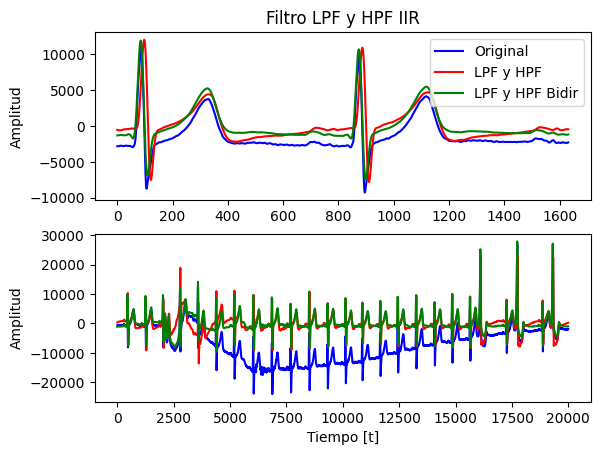

In [7]:
# Frecuencias de muestreo
f_cut_hpf   = 0.3
f_cut_lpf   = 35
N           = 4
   
sos_matrix_hpf = sig.butter(N = N, Wn = f_cut_hpf, btype = 'highpass', 
                            analog = False, fs = fs, output = 'sos')
   
sos_matrix_lpf = sig.butter(N = N, Wn = f_cut_lpf, btype = 'lowpass', 
                            analog = False, fs = fs, output = 'sos')

ecg_filt_hpf_1      = sig.sosfilt(sos_matrix_hpf, ecg_one_lead, axis = 0);
ecg_filt_filt_hpf_1 = sig.sosfiltfilt(sos_matrix_hpf, ecg_one_lead, axis = 0);
ecg_filt_1          = sig.sosfilt(sos_matrix_lpf, ecg_filt_hpf_1, axis = 0);
ecg_filt_filt_1     = sig.sosfiltfilt(sos_matrix_lpf, ecg_filt_filt_hpf_1, axis = 0);

ecg_time        = np.arange(0, len(ecg_one_lead), 1);
time_filt_norm  = (ecg_time > 4234) & (ecg_time < 5867);
time_filt_lp    = (ecg_time > 100000) & (ecg_time < 120000);

fig6, (ax1, ax2) = plt.subplots(2);
ax1.set_title('Filtro LPF y HPF IIR');
ax1.plot(ecg_one_lead[time_filt_norm],      'b', label = 'Original');
ax1.plot(ecg_filt_1[time_filt_norm],        'r', label = 'LPF y HPF');
ax1.plot(ecg_filt_filt_1[time_filt_norm],   'g', label = 'LPF y HPF Bidir');
ax1.set(ylabel = 'Amplitud');
ax1.legend(loc = 'upper right');
ax2.plot(ecg_one_lead[time_filt_lp],      'b', label = 'Original');
ax2.plot(ecg_filt_1[time_filt_lp],        'r', label = 'LPF y HPF');
ax2.plot(ecg_filt_filt_1[time_filt_lp],   'g', label = 'LPF y HPF Bidir');
ax2.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');

Decidí tomar porciones de la señal que me parecían representativas para mostrar el comportamiento de los filtros, ya que de otra manera, la visualización hubiese sido imposible. 

En el gráfico superior, se puede observar como se elimina el ruido de alta frecuencia y a su vez, al utilizar filtros bidireccionales, se elimina cualquier distorsión de fase (entre las muestras 400 y 800 de la <font color='red'> señal roja </font> se aprecia claramente). Por otro lado, en el gráfico inferior, observamos como  se elimina el ruido de baja frecuencia.

Ahora voy a continuar con **un pasabanda**:

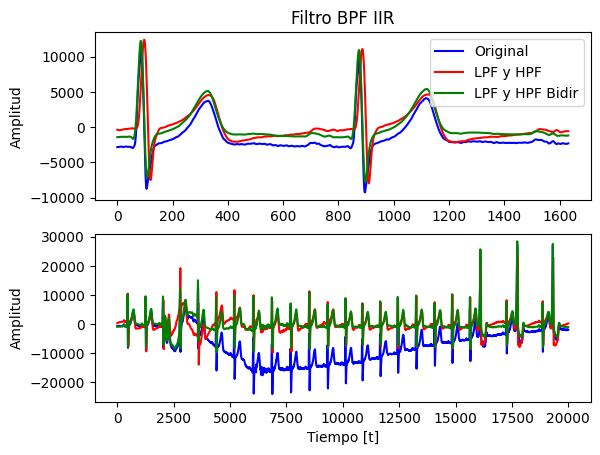

In [8]:
ripple      = 0.5 # dB
atenuacion  = 20  # dB

ws1 = 0.03 #Hz
wp1 = 0.3  #Hz
wp2 = 35.0 #Hz
ws2 = 70.0 #Hz
    
frecs    = np.array([0, ws1, wp1, wp2, ws2, (fs//2)])
gains    = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, 0])
gains    = 10**(gains/20)
gains[5] = 0

sos_bpf         = filter_design(ripple, atenuacion, ws1, wp1, wp2, ws2, fs);
ecg_filt_2      = sig.sosfilt(sos_bpf, ecg_one_lead, axis = 0);
ecg_filt_filt_2 = sig.sosfiltfilt(sos_bpf, ecg_one_lead, axis = 0);

fig7, (ax1, ax2) = plt.subplots(2);
ax1.set_title('Filtro BPF IIR');
ax1.plot(ecg_one_lead[time_filt_norm],      'b', label = 'Original');
ax1.plot(ecg_filt_2[time_filt_norm],        'r', label = 'LPF y HPF');
ax1.plot(ecg_filt_filt_2[time_filt_norm],   'g', label = 'LPF y HPF Bidir');
ax1.set(ylabel = 'Amplitud');
ax1.legend(loc = 'upper right');
ax2.plot(ecg_one_lead[time_filt_lp],      'b', label = 'Original');
ax2.plot(ecg_filt_2[time_filt_lp],        'r', label = 'LPF y HPF');
ax2.plot(ecg_filt_filt_2[time_filt_lp],   'g', label = 'LPF y HPF Bidir');
ax2.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');

Para realizar el filtro probé otra función de la biblioteca signal que permite ser un poco mas riguroso con la plantilla del filtro, de todas formas para permitirme una comparación con el método anterior, intenté elegir parámetros que reproduzcan el resultado de la experiencia anterior. En la siguiente prueba, voy a intentar ser mas riguroso, disminuyendo la frecuencia superior de la banda de detenida y aumentaré la atenuación:

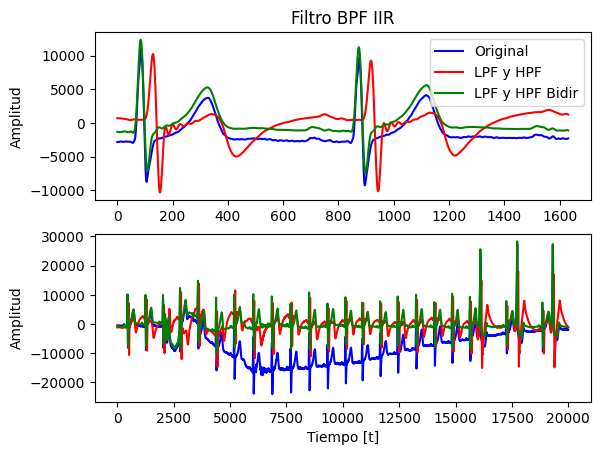

In [9]:
ripple      = 0.5 # dB
atenuacion  = 40  # dB

ws1 = 0.03 #Hz
wp1 = 0.3  #Hz
wp2 = 35.0 #Hz
ws2 = 50.0 #Hz
    
frecs    = np.array([0, ws1, wp1, wp2, ws2, (fs//2)])
gains    = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, 0])
gains    = 10**(gains/20)
gains[5] = 0

sos_bpf         = filter_design(ripple, atenuacion, ws1, wp1, wp2, ws2, fs);
ecg_filt_2      = sig.sosfilt(sos_bpf, ecg_one_lead, axis = 0);
ecg_filt_filt_2 = sig.sosfiltfilt(sos_bpf, ecg_one_lead, axis = 0);

fig7, (ax1, ax2) = plt.subplots(2);
ax1.set_title('Filtro BPF IIR');
ax1.plot(ecg_one_lead[time_filt_norm],      'b', label = 'Original');
ax1.plot(ecg_filt_2[time_filt_norm],        'r', label = 'LPF y HPF');
ax1.plot(ecg_filt_filt_2[time_filt_norm],   'g', label = 'LPF y HPF Bidir');
ax1.set(ylabel = 'Amplitud');
ax1.legend(loc = 'upper right');
ax2.plot(ecg_one_lead[time_filt_lp],      'b', label = 'Original');
ax2.plot(ecg_filt_2[time_filt_lp],        'r', label = 'LPF y HPF');
ax2.plot(ecg_filt_filt_2[time_filt_lp],   'g', label = 'LPF y HPF Bidir');
ax2.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');

Observamos como la respuesta en fase del filtro se va degradando (lo podemos ver en la distorisón que introduce). Por otro lado, utilizando filtros bidireccionales, estos problemas nuevamente desaparecen.

Por último, voy a realizar la **misma experiencia pero utilizando filtros FIR**

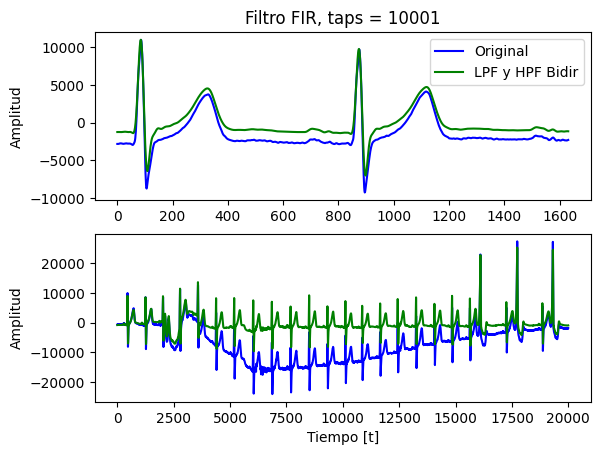

In [10]:
num_win         = sig.firwin2(10001, frecs, gains , window=('kaiser', 14), fs = fs)
ecg_filt_filt_3 = sig.filtfilt(num_win, 1, ecg_one_lead, axis = 0)

fig8, (ax1, ax2) = plt.subplots(2);
ax1.set_title('Filtro FIR, taps = 10001');
ax1.plot(ecg_one_lead[time_filt_norm],      'b', label = 'Original');
ax1.plot(ecg_filt_filt_3[time_filt_norm],   'g', label = 'LPF y HPF Bidir');
ax1.set(ylabel = 'Amplitud');
ax1.legend(loc = 'upper right');
ax2.plot(ecg_one_lead[time_filt_lp],      'b', label = 'Original');
ax2.plot(ecg_filt_filt_3[time_filt_lp],   'g', label = 'LPF y HPF Bidir');
ax2.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');

La <font color='green'>**ventaja**</font> de utilizar filtros FIR simétricos es que su fase será lineal, por lo que no tendremos los problemas antes descriptos. La <font color='red'>**desventaja**</font>, es que se necesita una gran cantidad de coeficientes para igualar el comportamiento de los filtros IIR. Repetiré la misma experiencia pero disminuyendo la cantidad de taps a 1001

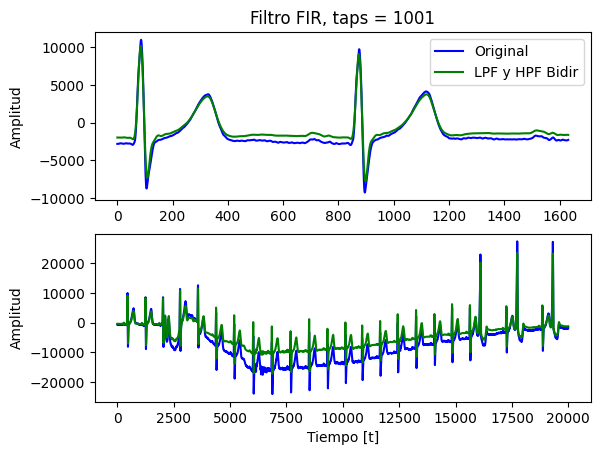

In [11]:
num_win         = sig.firwin2(1001, frecs, gains , window=('kaiser', 14), fs = fs)
ecg_filt_filt_3 = sig.filtfilt(num_win, 1, ecg_one_lead, axis = 0)

fig8, (ax1, ax2) = plt.subplots(2);
ax1.set_title('Filtro FIR, taps = 1001');
ax1.plot(ecg_one_lead[time_filt_norm],      'b', label = 'Original');
ax1.plot(ecg_filt_filt_3[time_filt_norm],   'g', label = 'LPF y HPF Bidir');
ax1.set(ylabel = 'Amplitud');
ax1.legend(loc = 'upper right');
ax2.plot(ecg_one_lead[time_filt_lp],      'b', label = 'Original');
ax2.plot(ecg_filt_filt_3[time_filt_lp],   'g', label = 'LPF y HPF Bidir');
ax2.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');

El comportamiento en alta frecuencia parece ser bastante bueno, pero rapidamente vemos que no alcanza la cantidad de coeficientes para igualar la exigencia del filtro anterior.

#### Filtrado Alineal

El objetivo de las siguientes técnicas es eliminar a través de métodos no convencionales el ruido de baja frecuencia, no serán útiles para eliminar cualquier ruido de alta frecuencia como veremos a continuación.

La primera de ellas se basa en la estimación del movimiento de línea de base a partir de los segmentos isoeléctricos de cada latido. A partir de las detecciones provistas se puede estimar aproximadamente el nivel isoeléctrico, es decir, el momento donde la actividad eléctrica cardíaca es nula. El intervalo entre la onda P y Q es un buen punto para estimar las características de las señales interferentes que originan el movimiento de la línea de base. Para ello, voy a localizar cada uno de los latidos (previamente realizado) y voy a retroceder unos 120ms para encontrar el punto de interes. Una vez encontrados, voy a realizar una interpolación de ellos para obtener la función interpolante. Por último, voy a restar la interpolante a la señal original

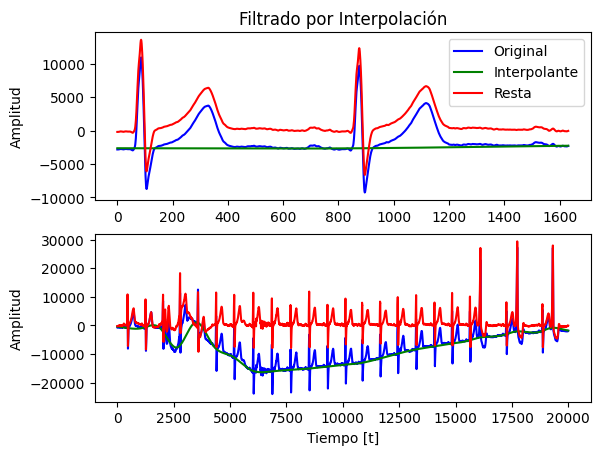

In [12]:
from scipy import interpolate as interp

# Filtrado por interpolación
ms_to_sample = 120.0; # Cantidad de ms que voy a retroceder desde el pico
n_samples_to_backward = (int)(ms_to_sample/1000.0 * fs); # Cantidad de muestras que retrocedo
isoelectric_sample = np.empty((n_run, 1), float);
isoelectric_sample_t = np.empty((n_run, 1), int);
for i in range(n_run):
    index = qrs_peak[i][0];
    isoelectric_sample_t[i] = index - n_samples_to_backward;
    isoelectric_sample[i] = ecg_one_lead[isoelectric_sample_t[i]]
time_grid = np.arange(0, len(ecg_one_lead), 1);
isoelectric_interp = interp.CubicSpline(isoelectric_sample_t.flatten(), isoelectric_sample);
isolectric_frame = isoelectric_interp(time_grid);

fig8, (ax1, ax2) = plt.subplots(2);
ax1.set_title('Filtrado por Interpolación');
ax1.plot(ecg_one_lead[time_filt_norm],      'b', label = 'Original');
ax1.plot(isolectric_frame[time_filt_norm],   'g', label = 'Interpolante');
ax1.plot(ecg_one_lead[time_filt_norm]-isolectric_frame[time_filt_norm],   'r', label = 'Resta');
ax1.set(ylabel = 'Amplitud');
ax1.legend(loc = 'upper right');
ax2.plot(ecg_one_lead[time_filt_lp],      'b', label = 'Original');
ax2.plot(isolectric_frame[time_filt_lp],   'g', label = 'Interpolante');
ax2.plot(ecg_one_lead[time_filt_lp]-isolectric_frame[time_filt_lp],   'r', label = 'Resta');
ax2.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');

Para el próximo método voy a realizar una estimación del movimiento de línea de base a partir del filtrado de mediana. A partir de la siguiente estimación del movimiento de línea de base
$$\hat{b}=med_{600}(med_{200}(S))$$

Donde S representa la señal de ECG a partir de la que estimamos el movimiento de la línea de base $\hat{b}$. Una vez obtenido dicho valor, se lo restará a la señal original para eliminar la interferencia en baja frecuencia:

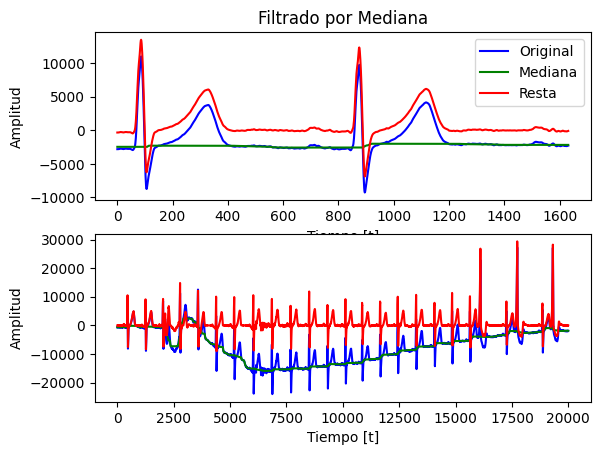

In [13]:
# Filtrado por mediana
kernel_200  = (int)(200/1000*fs)+1;
kernel_600  = (int)(600/1000*fs)+1;
ecg_frame = ecg_one_lead[:];
med_200     = sig.medfilt(ecg_frame.flatten(), kernel_200)
med_600     = sig.medfilt(med_200, kernel_600)
median_ecg = np.transpose(ecg_one_lead)-med_600

fig9, (ax1, ax2) = plt.subplots(2);
ax1.set_title('Filtrado por Mediana');
ax1.plot(ecg_one_lead[time_filt_norm],      'b', label = 'Original');
ax1.plot(med_600[time_filt_norm],   'g', label = 'Mediana');
ax1.plot(np.transpose(median_ecg)[time_filt_norm], 'r', label = 'Resta');
ax1.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');
ax1.legend(loc = 'upper right');
ax2.plot(ecg_one_lead[time_filt_lp],      'b', label = 'Original');
ax2.plot(med_600[time_filt_lp],   'g', label = 'Interpolante');
ax2.plot(np.transpose(median_ecg)[time_filt_lp],   'r', label = 'Resta');
ax2.set(xlabel = 'Tiempo [t]', ylabel = 'Amplitud');

Si observamos los resultados obtenidos anteriormente, veremos que la linea base (baja frecuencia) se remueve por completo, pero no hicimos nada con el ruido de alta frecuencia. Si hacemos foco en los gráficos superiores vemos como la señal resultantes sigue teniendo ese ruido montado, cosa que no pasaba cuando se utilizaban las técnicas clásicas de filtrado